# Nonparametrics

In nonparametric analysis, few, if any, assumptions are made about the relationship between x and y and algorithms will seek to explain more of the true relationship between x and y as more data is accumulated. In essence, fully nonparametric analysis only holds the assumption of independence between observations.

## Decision Trees

A decision tree is a logical system for mapping inputs to outcomes. The construction of a decision tree follows our usual line of reasoning: minimize the loss function (whether that be the usual deviance or some other type of loss function such as Gini Impurity which is commonly used for trees). However, a decision tree is constructed by taking our x covariates and deciding a series of hierarchial splits in order to minimize the loss function of choice.

The most commonly used tree algorithm is CART (Classification and Regression Tree) which is conducted by
1. Determine the single error minimizing split for this data sample – location xij that minimizes the loss across children.
2. Split this parent node into two children.
3. Apply steps 1-2 to each child node. This continues recursively until you reach a leaf node of some pre- specified minimum size (e.g., stop splitting when there are fewer than, say, 10 observations in each leaf).

#### To understand the use of decision trees, we will return to the NBC datset to see fi we can predict the genre of a tv show based of a set of show characteristics.

In [22]:
#Set the working directory to the specific location of the files on your computer
#note: In this case, the working directory was set for my computer
setwd("/Users/Brandon/Harding_ML_Class")

#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

In [6]:
#Read in the NBC show characteristics
nbc <- read.csv("nbc_showdetails.csv")

In [15]:
#Load the show demographics for predicting genre
demos <- read.csv("nbc_demographics.csv", row.names=1)

#Assign the show genres to a variable
genre <- nbc$Genre

#View the types of genre
levels(genre)

[1] "Drama/Adventure"  "Reality"          "Situation Comedy"

In [8]:
##Fit a decision tree

#Load in the desired package
library("tree")

# Tree fit; it knows to fit a classification tree since genre is a factor.
# for two-level factors (e.g. spam) make sure you do factor(spam)
genretree <- tree(genre ~ .,
                  data=demos[,-1],
                  mincut=1 #describes the minimum number of observations that must be present in a child node for a split to occur
                 )

In [10]:
#View model summary of split points
genretree

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 40 75.800 Drama/Adventure ( 0.47500 0.42500 0.10000 )  
   2) WIRED.CABLE.W.O.PAY < 28.6651 22 33.420 Drama/Adventure ( 0.72727 0.09091 0.18182 )  
     4) VCR.OWNER < 83.749 5  6.730 Situation Comedy ( 0.00000 0.40000 0.60000 ) *
     5) VCR.OWNER > 83.749 17  7.606 Drama/Adventure ( 0.94118 0.00000 0.05882 )  
      10) TERRITORY.PACIFIC < 13.6859 1  0.000 Situation Comedy ( 0.00000 0.00000 1.00000 ) *
      11) TERRITORY.PACIFIC > 13.6859 16  0.000 Drama/Adventure ( 1.00000 0.00000 0.00000 ) *
   3) WIRED.CABLE.W.O.PAY > 28.6651 18 16.220 Reality ( 0.16667 0.83333 0.00000 )  
     6) BLACK < 17.2017 15  0.000 Reality ( 0.00000 1.00000 0.00000 ) *
     7) BLACK > 17.2017 3  0.000 Drama/Adventure ( 1.00000 0.00000 0.00000 ) *

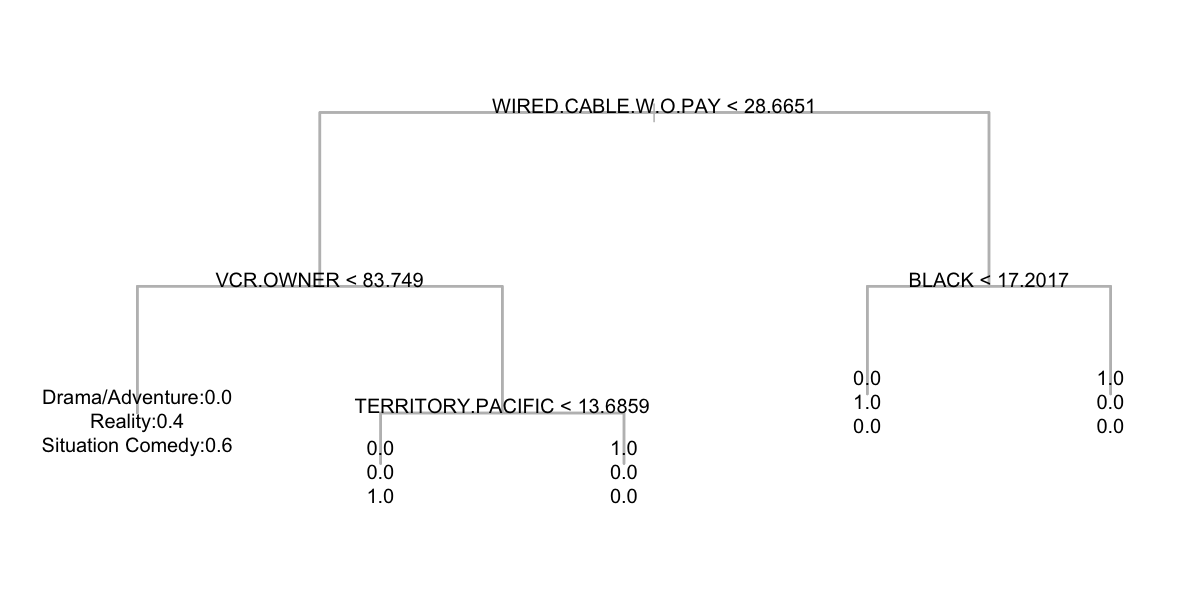

In [9]:
##Create a dendogram plot of the tree (show the hierarchy of the splits)

#Create the split levels
plot(genretree, col=8, lwd=2)

#Print the predictive probabilities
text(genretree, label="yprob")

In [56]:
## example of prediction (type="class"  to get max prob classifications back)
genrepred <- predict(genretree,
                     newdata=demos[,-1],
                     type="class" #signal that you want the predictions as a classification (yprob gets probability predictions)
                    )

genrepred[1:5]

[1] Reality         Drama/Adventure Reality         Reality        
[5] Reality        
Levels: Drama/Adventure Reality Situation Comedy

#### Now we want to predict expected viewer engagement (PE) based on the show's genre and gross ratings points (GRP is the estimated total number of views of the show).

In [12]:
##Create a design matrix such that we avoid dealing with text data

#Create design matrix
x <- as.data.frame(model.matrix(PE ~ Genre + GRP, data=nbc)[,-1])

#Rename columns
names(x) <- c("reality","comedy","GRP")

In [13]:
#Fit a tree
nbctree <- tree(nbc$PE ~ ., data=x, mincut=1)

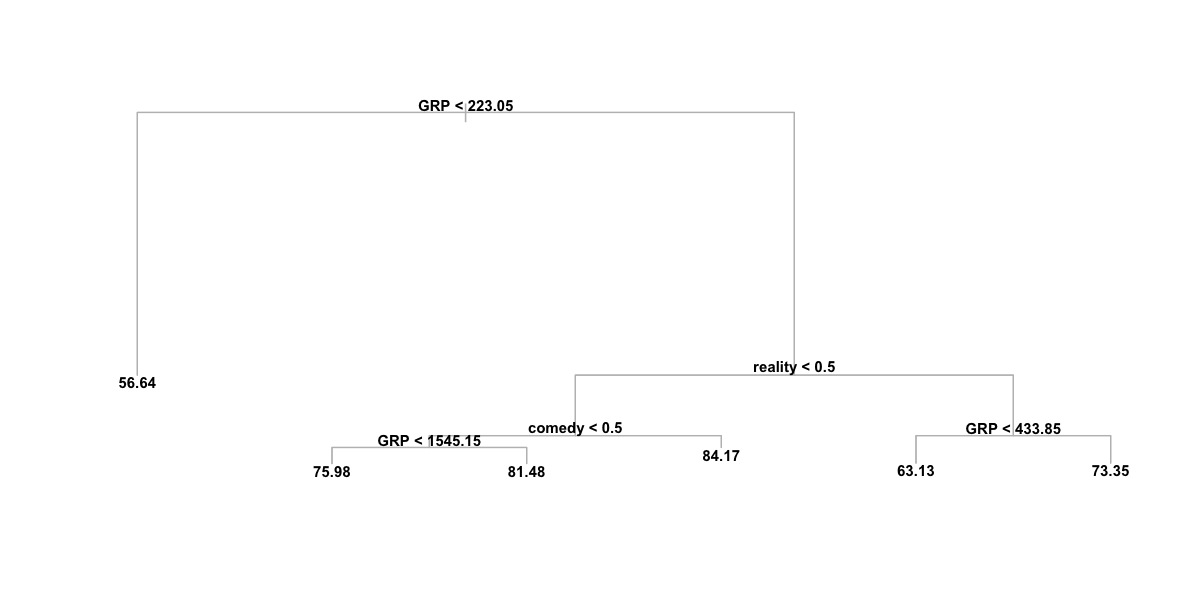

In [14]:
#Plot a dendrogram of the above fit
plot(nbctree, col=8)
text(nbctree, cex=.75, font=2)

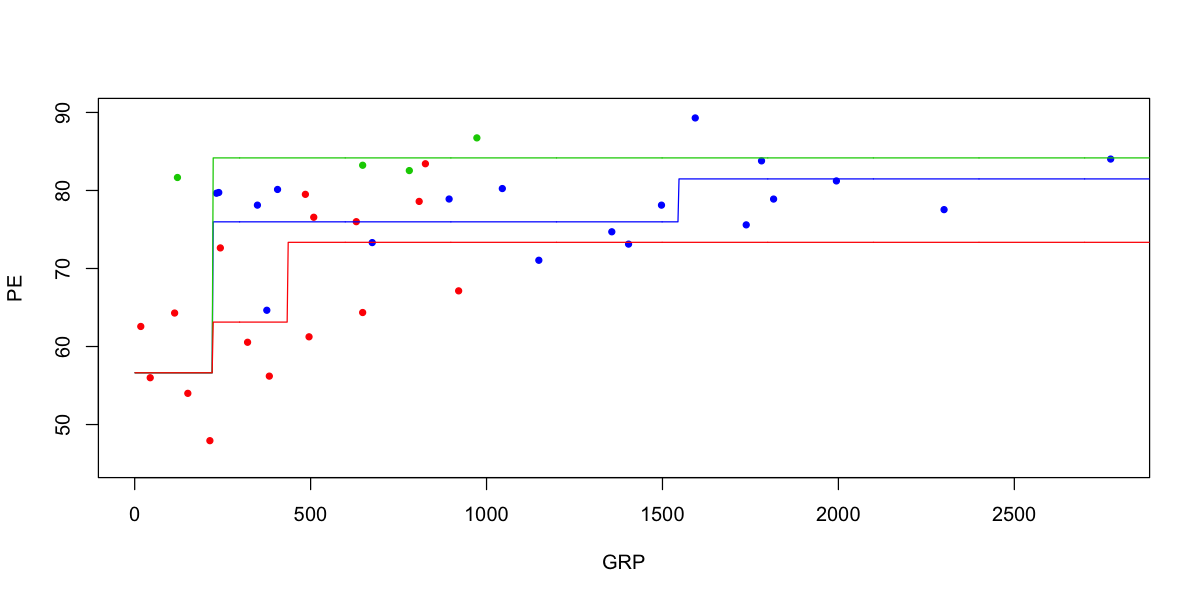

In [16]:
###Plot PE versus GRP observed and predicted

##Plot the observed GRP against the PE
plot(PE ~ GRP, data=nbc, col=c(4,2,3)[nbc$Genre], pch=20, ylim=c(45,90))

##Plot predicted GRP

#Create a sequence of GRP values to predict
newgrp <- seq(1,3000,length=1000)

#Plot predicted GRP values for different show genres
lines(newgrp, predict(nbctree, newdata=data.frame(GRP=newgrp, drama=1, comedy=0, reality=0)), col=4)
lines(newgrp, predict(nbctree, newdata=data.frame(GRP=newgrp, drama=0, comedy=1, reality=0)), col=3)
lines(newgrp, predict(nbctree, newdata=data.frame(GRP=newgrp, drama=0, comedy=0, reality=1)), col=2)


#### While it is easy to overfit decision trees, the use of tree pruning and cross validation can reduce the magnitude and control for overfitting effects. The idea of pruning is to remove the splits that yield the lowest in-sample error reduction. Thus, we are preventing our tree from learning relationships between the covariates and the response that are merely random noise in the data.

#### We will use a dataset on prostate cancer in predicting the tumor sizes to demonstrate these techniques.

In the prostate cancer dataset, the variables included are as follows

- lcavol: log(cancer volume), the response of interest
- age: age
- lbph: log(benign prostatic hyperplasia amount)
- lcp: log(capsular penetration)
- gleason: Gleason score
- lpsa: log(prostate specific antigen)

#### First we will fit a single decision tree without cross validation and pruning as a benchmark, and then implement the techniques

In [17]:
#Load prostate cancer dataset
prostate <- read.csv("prostate.csv")

In [18]:
#View structure of the dataset
str(prostate)

'data.frame':	97 obs. of  6 variables:
 $ lcavol : num  -0.58 -0.994 -0.511 -1.204 0.751 ...
 $ age    : int  50 58 74 58 62 50 64 58 47 63 ...
 $ lbph   : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ lcp    : num  -1.39 -1.39 -1.39 -1.39 -1.39 ...
 $ gleason: int  6 6 7 6 6 6 6 6 6 6 ...
 $ lpsa   : num  -0.431 -0.163 -0.163 -0.163 0.372 ...


In [19]:
#Fit a decision tree to predict log tumor volume (lcavol) based on the other covariates with no pruning or cross validation
pstree <- tree(lcavol ~., data=prostate, mincut=1)

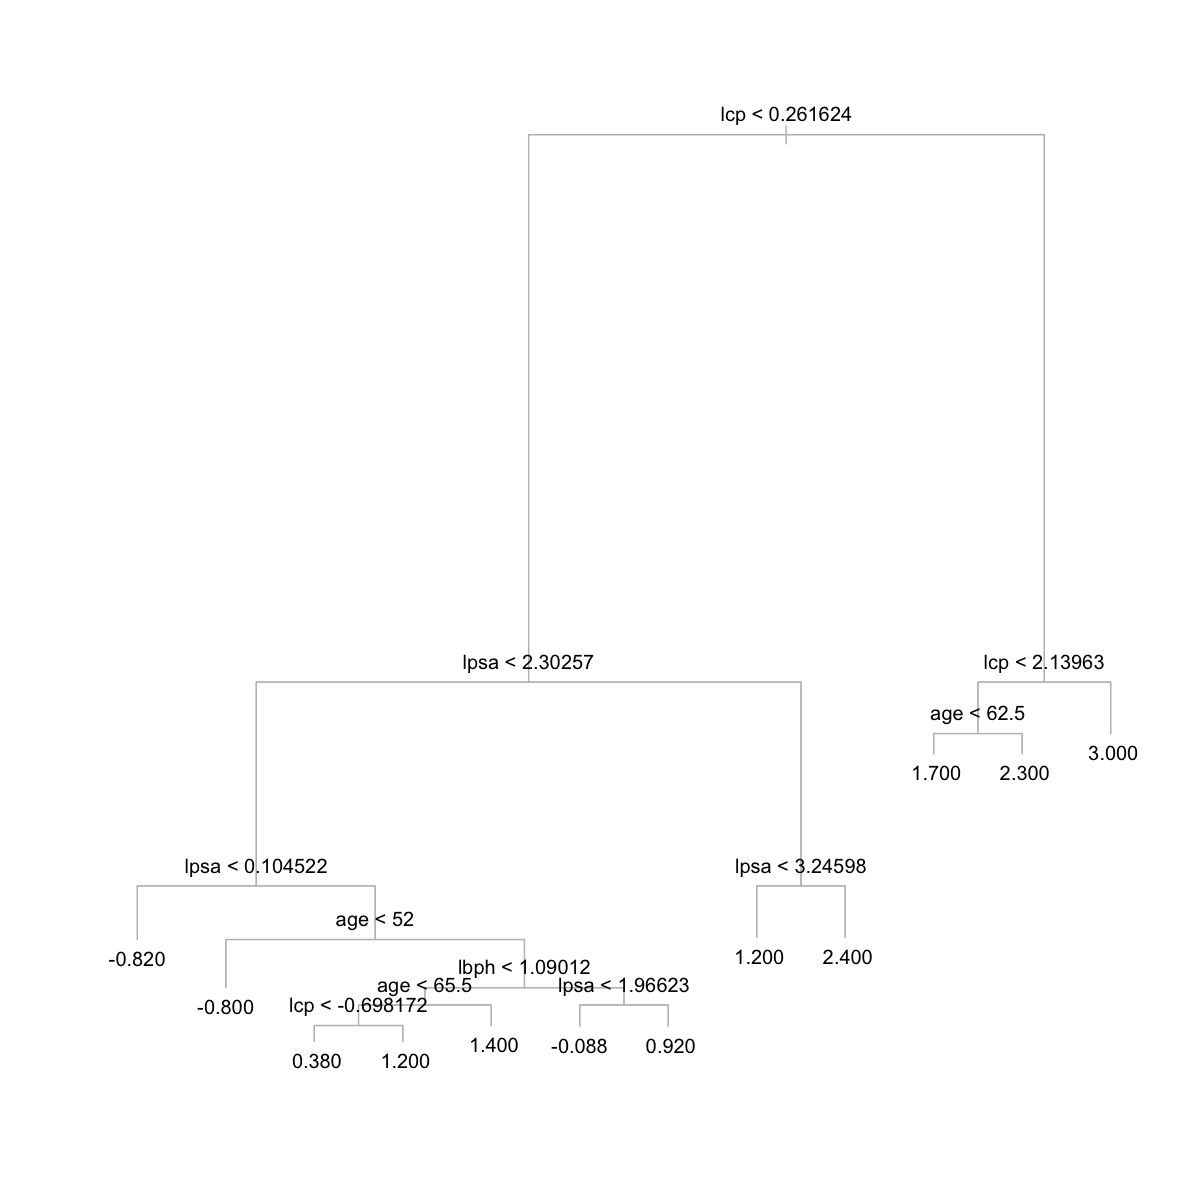

In [23]:
#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 10)

#Plot the tree dendrogram
plot(pstree, col=8)
text(pstree, digits=2)

In [24]:
#Use cross-validation to prune the tree
cvpst <- cv.tree(pstree,
                 K=10 #number of cross validation folds
                )

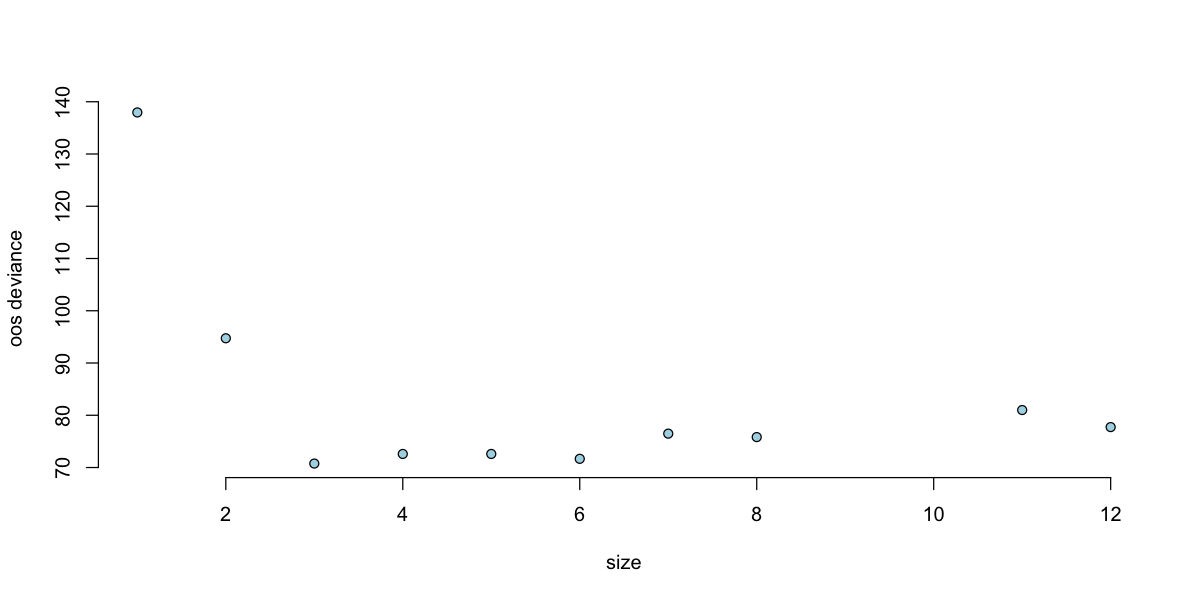

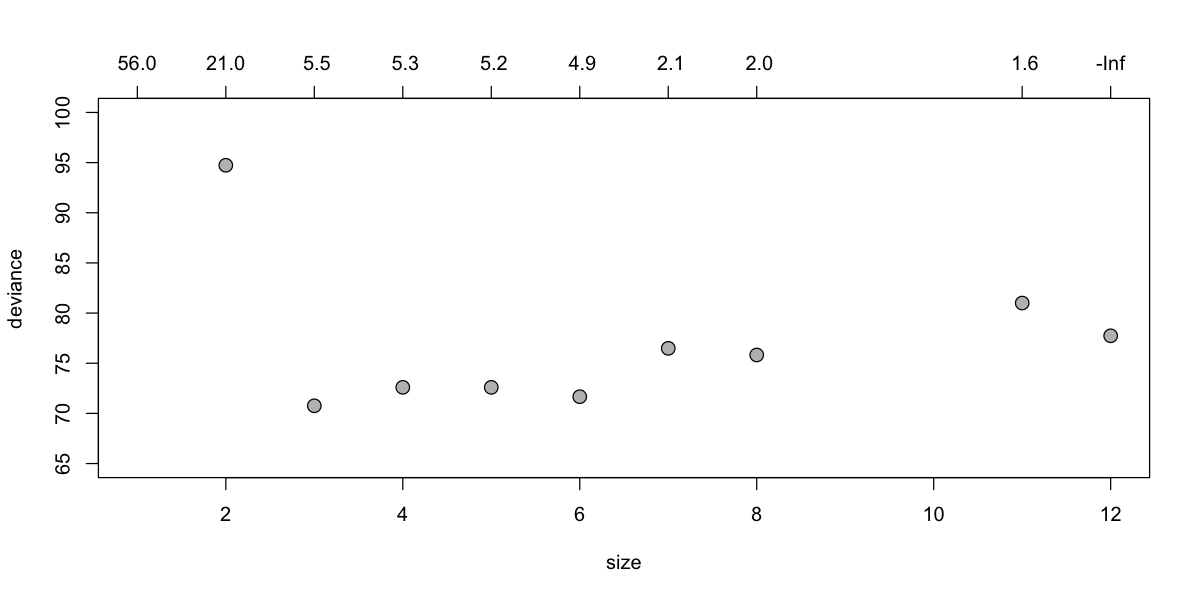

In [28]:
#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

#Plot out of sample deviance for the the various tree sizes
plot(cvpst$size, cvpst$dev, xlab="size", ylab="oos deviance", pch=21, bg="lightblue", bty="n")

#Plot out of sample deviance for the the various tree sizes with average leaf size on top of plot
plot(cvpst, pch=21, bg=8, type="p", cex=1.5, ylim=c(65,100))

In [29]:
## The tree with 3 leaves is best and we will now select this tree
## by pruning our original tree to this size.
pstcut <- prune.tree(pstree, best=3)

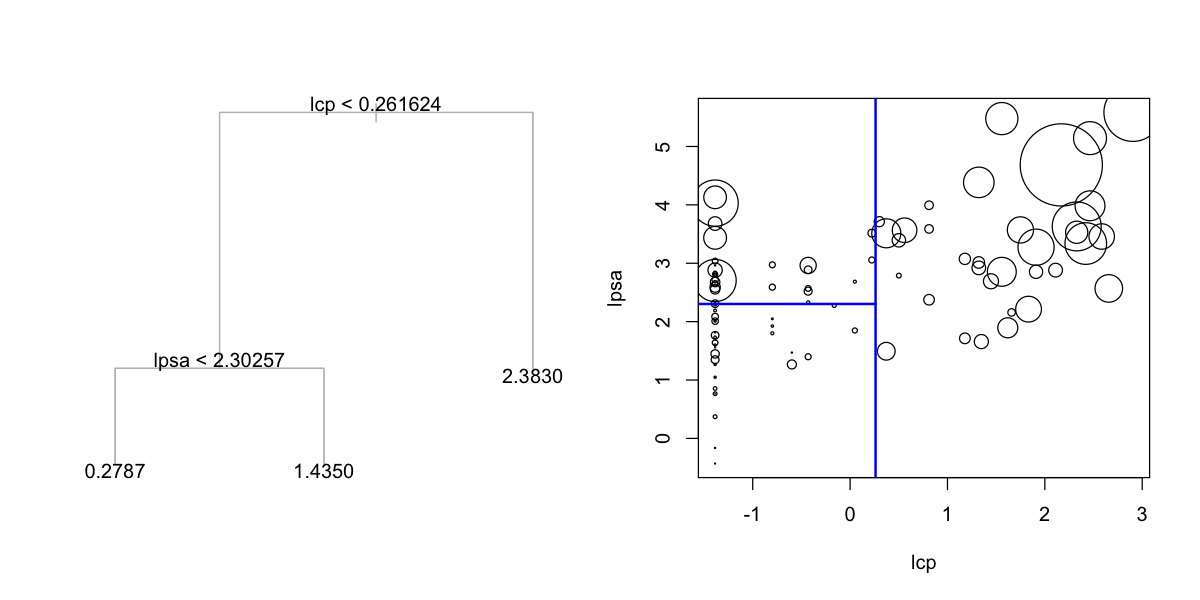

In [30]:
##Create two plots

par(mfrow=c(1,2))

#On left: Plot dendrogram of best tree
plot(pstcut, col=8)
text(pstcut)

#Plot the decision boundary based on the two covariates for tumor sizes
# note: the decision boundary is constructed based on the split points
plot(prostate[,c("lcp","lpsa")], cex=exp(prostate$lca)*.2)
# lcp boundary
abline(v=.261624, col=4, lwd=2)
# lpsa decision boundary
lines(x=c(-2,.261624), y=c(2.30257,2.30267), col=4, lwd=2)

## Random Forests

A random forest can overcome the overfitting problems associated with individual decision trees by fitting a series of CART trees on with-replacement samples of the data. Thus, the random forest algorithm works by
1. Take a random sample with-replacement of n observations in the data.
2. Fit a CART tree to the data.
3. Take the average of all the CART tree predictions as the final prediction for an observation.

#### Let's illustrate an example of a random forest using the motorcycle data within the MASS package. First, we will demonstrate the flexibility of the CART tree on fitting to data and then demonstrate the power of teh random forest. The dataset describes 133 measurements of acceleration of a motorcycle rider's helmet in the moments after a head-on collision.

In [1]:
#Import MASS library
library("MASS")

#Import motorcycle dataset from MASS library
data(mcycle)

In [2]:
#View structure of the dataset
str(mcycle)

'data.frame':	133 obs. of  2 variables:
 $ times: num  2.4 2.6 3.2 3.6 4 6.2 6.6 6.8 7.8 8.2 ...
 $ accel: num  0 -1.3 -2.7 0 -2.7 -2.7 -2.7 -1.3 -2.7 -2.7 ...


In [48]:
summary(mcycle)

     times           accel        
 Min.   : 2.40   Min.   :-134.00  
 1st Qu.:15.60   1st Qu.: -54.90  
 Median :23.40   Median : -13.30  
 Mean   :25.18   Mean   : -25.55  
 3rd Qu.:34.80   3rd Qu.:   0.00  
 Max.   :57.60   Max.   :  75.00  

In [68]:
#Fit CART
mtree <- tree(accel ~., data=mcycle)

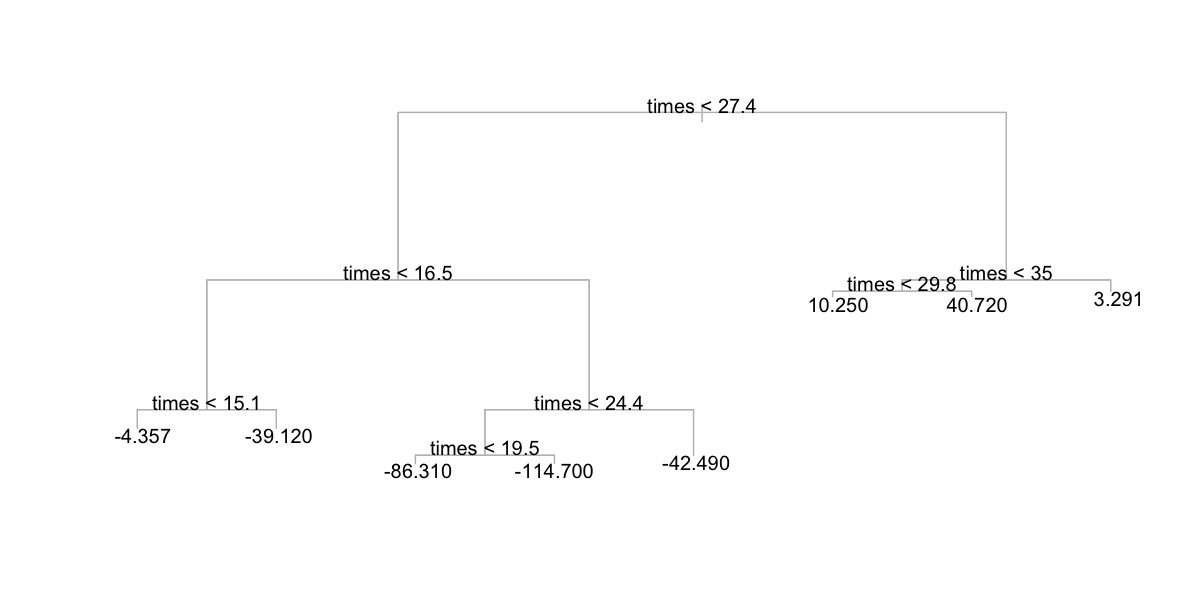

In [75]:
#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

#Plot the tree dendrogram
plot(mtree, col=8)
text(mtree, digits=4)

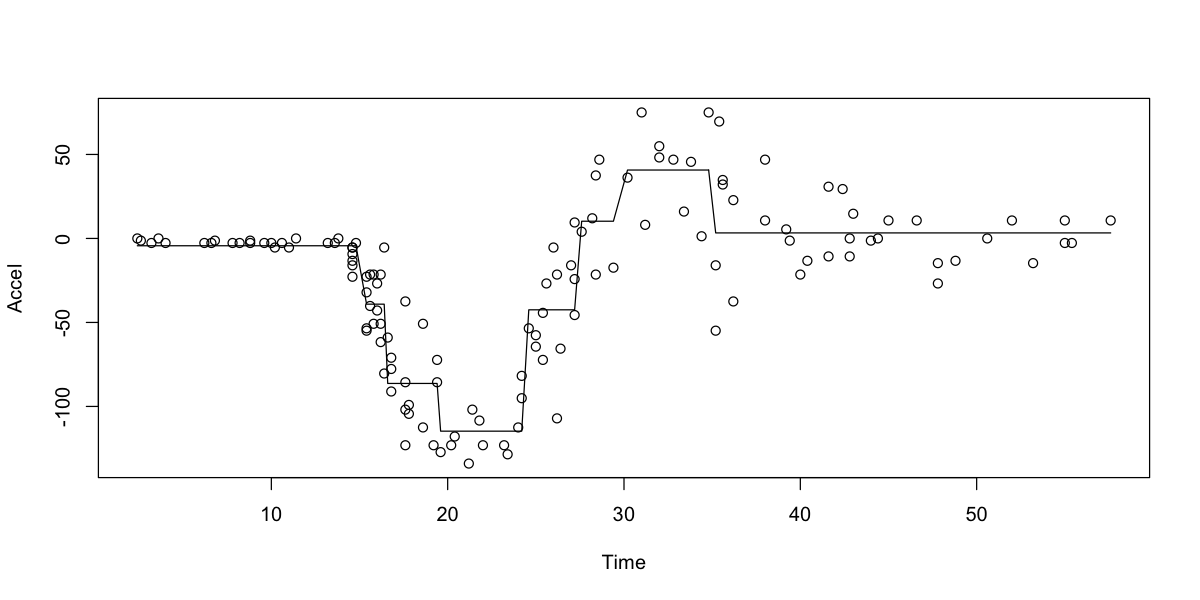

In [74]:
##Plot the observed versus predicted acceleration

#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

#Get acceleration predictions on data
mtree_pred <- predict(mtree, newdata=mcycle)

#Plot actual acceleration values
plot(mcycle$times, mcycle$accel, xlab="Time", ylab="Accel")

#Plot predicted accel
points(mcycle$times, mtree_pred, type="l")

#### Now perform a random forest by bootstrapping CART trees on with-replacement samples of the mcycle dataset.

In [77]:
## Random forest bootstrap with 10 trees (aka 10 bootstrap samples)

#Set number of samples to be taken
B <- 10

#Create an empty list to store the CART trees
forest10 <- list()

#Contsruct a for-loop to construct CART trees
for (b in 1:B){
    #Sample indicies with replacement from 1 to the number of observations in browser
    samp_b <- sample.int(nrow(mcycle), replace=TRUE)
    #Build CART tree on sample of mcycle
    b_tree <- mtree <- tree(accel ~., data=mcycle[samp_b,])
    #Add tree to forest
    forest10[[b]] <- b_tree
}

In [78]:
## Random forest bootstrap with 100 trees (aka 100 bootstrap samples)

#Set number of samples to be taken
B <- 100

#Create an empty list to store the CART trees
forest100 <- list()

#Contsruct a for-loop to construct CART trees
for (b in 1:B){
    #Sample indicies with replacement from 1 to the number of observations in browser
    samp_b <- sample.int(nrow(mcycle), replace=TRUE)
    #Build CART tree on sample of mcycle
    b_tree <- mtree <- tree(accel ~., data=mcycle[samp_b,])
    #Add tree to forest
    forest100[[b]] <- b_tree
}

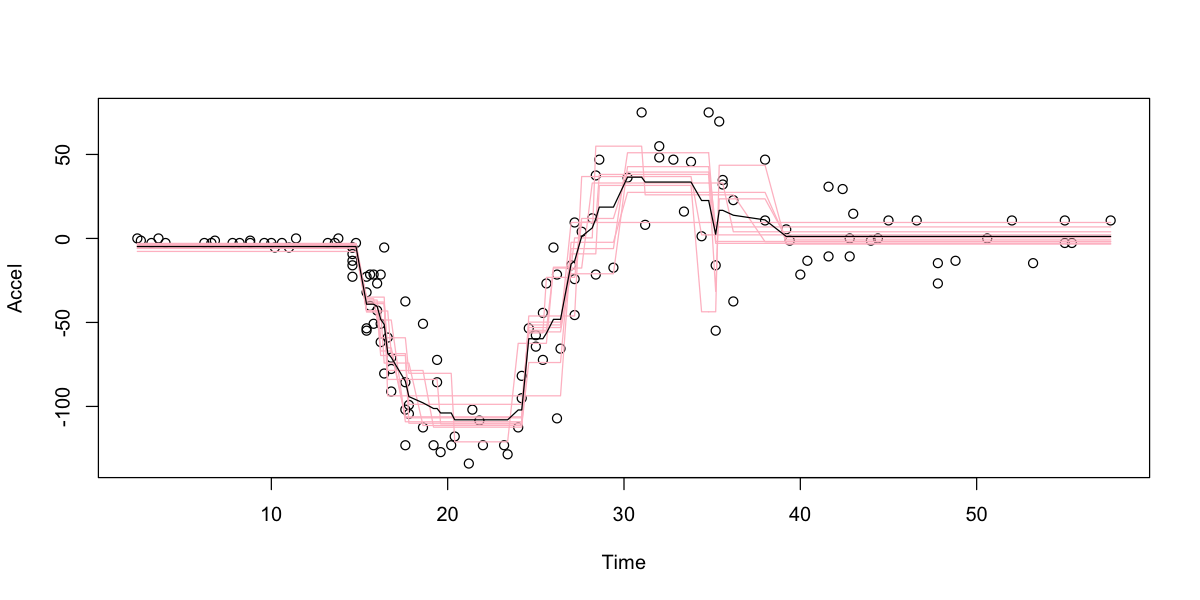

In [80]:
###Plot fit of 10 CART trees

##Plot actual acceleration values
plot(mcycle$times, mcycle$accel, xlab="Time", ylab="Accel")

##Construct list to store predictions of each tree
pred10 <- list()

##Construct for-loop to make predictions and plot fit for each tree
for (b in 1:10) {
    #Get acceleration predictions on data
    mtree_pred <- predict(forest100[[b]], newdata=mcycle)
    #Store predictions
    pred10[[b]] <- mtree_pred
    #Plot predicted accel
    points(mcycle$times, mtree_pred, type="l", col="pink")
}

##Plot mean prediction fit

#Create a data frame with all the predictions
pred10 <- as.data.frame(pred10)

# Note: each row of the data frame is each tree's prediction for the observation number
#       Thus, taking the mean of each row can get us our our average predictions.

#Get average of each observation's predictions
mean_pred10 <- apply(pred10, 1, mean)

#Plot average predicted accel
points(mcycle$times, mean_pred10, type="l", col="black")

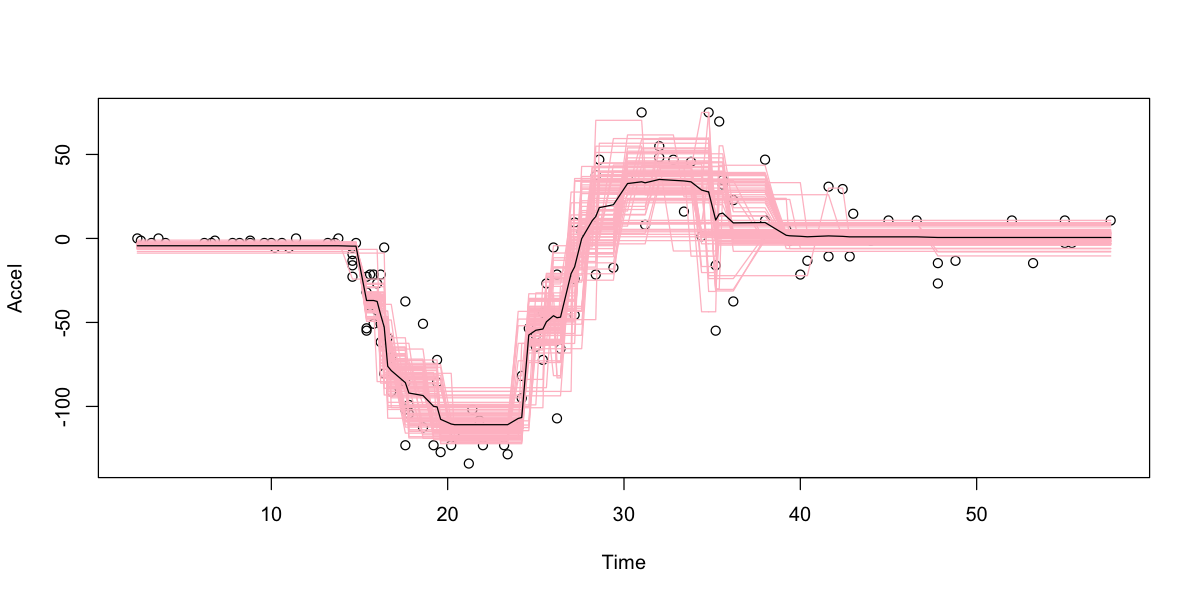

In [82]:
###Plot fit of 100 CART trees

##Plot actual acceleration values
plot(mcycle$times, mcycle$accel, xlab="Time", ylab="Accel")

##Construct list to store predictions of each tree
pred100 <- list()

##Construct for-loop to make predictions and plot fit for each tree
for (b in 1:100) {
    #Get acceleration predictions on data
    mtree_pred <- predict(forest100[[b]], newdata=mcycle)
    #Store predictions
    pred100[[b]] <- mtree_pred
    #Plot predicted accel
    points(mcycle$times, mtree_pred, type="l", col="pink")
}

##Plot mean prediction fit

#Create a data frame with all the predictions
pred100 <- as.data.frame(pred100)

# Note: each row of the data frame is each tree's prediction for the observation number
#       Thus, taking the mean of each row can get us our our average predictions.

#Get average of each observation's predictions
mean_pred100 <- apply(pred100, 1, mean)

#Plot average predicted accel
points(mcycle$times, mean_pred100, type="l", col="black")

### We will now demonstrate the use of random forest within the ranger package. This example will walk through the CAHousing.csv dataset with our goal of predicting median home value from the available data.

In [84]:
#Import useful libraries
library("tree")
library("ranger")
library("glmnet")

#Import data
CAhousing <- read.csv("CAhousing.csv")

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [85]:
##Perform data cleaning

#Create average statistics
CAhousing$AveBedrms <- CAhousing$totalBedrooms/CAhousing$households
CAhousing$AveRooms <- CAhousing$totalRooms/CAhousing$households
CAhousing$AveOccupancy <- CAhousing$population/CAhousing$households

#Establish the response variable
logMedVal <- log(CAhousing$medianHouseValue)

#Format dataframe
CAhousing <- CAhousing[,-c(4,5,9)] # lose medval and the room totals
CAhousing$logMedVal <- logMedVal # attach to the DF

In [91]:
## create a full matrix of interactions (only necessary for linear model)
## do the normalization only for main variables.
XXca <- model.matrix(~.*longitude*latitude, data=data.frame(scale(CAhousing)))[,-1]

#Fit a lasso regression
capen <- cv.glmnet(x=XXca, y=logMedVal, lambda.min.ratio=1e-4, nfolds=5)

Warning message in plotCoef(x$beta, lambda = x$lambda, df = x$df, dev = x$dev.ratio, :
“1 or less nonzero coefficients; glmnet plot is not meaningful”

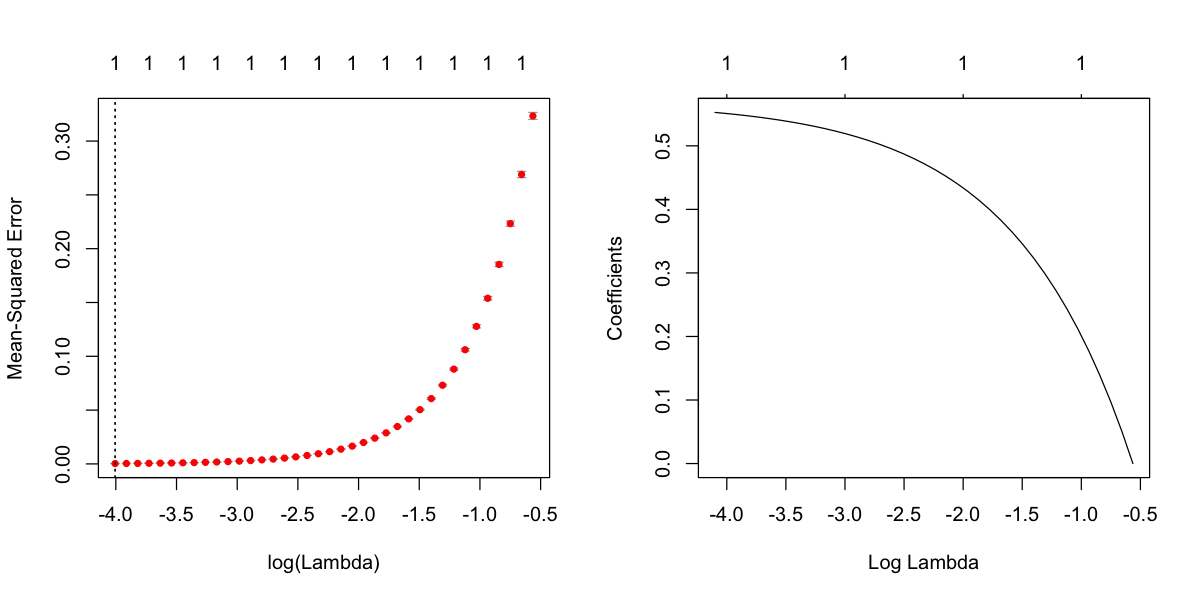

In [98]:
### As a point of comparison, run a lasso linear model.

## create a full matrix of interactions (only necessary for linear model)
## do the normalization only for main variables.
XXca <- model.matrix(~.*longitude*latitude, data=data.frame(scale(CAhousing)))[,-1]

#Fit a lasso regression
capen <- cv.glmnet(x=XXca, y=logMedVal, lambda.min.ratio=1e-4, nfolds=5)

## what would a lasso linear model fit look like?
## it likes a pretty complicated model
par(mfrow=c(1,2))
plot(capen)
plot(capen$glmnet.fit, xvar="lambda")

[1] 12

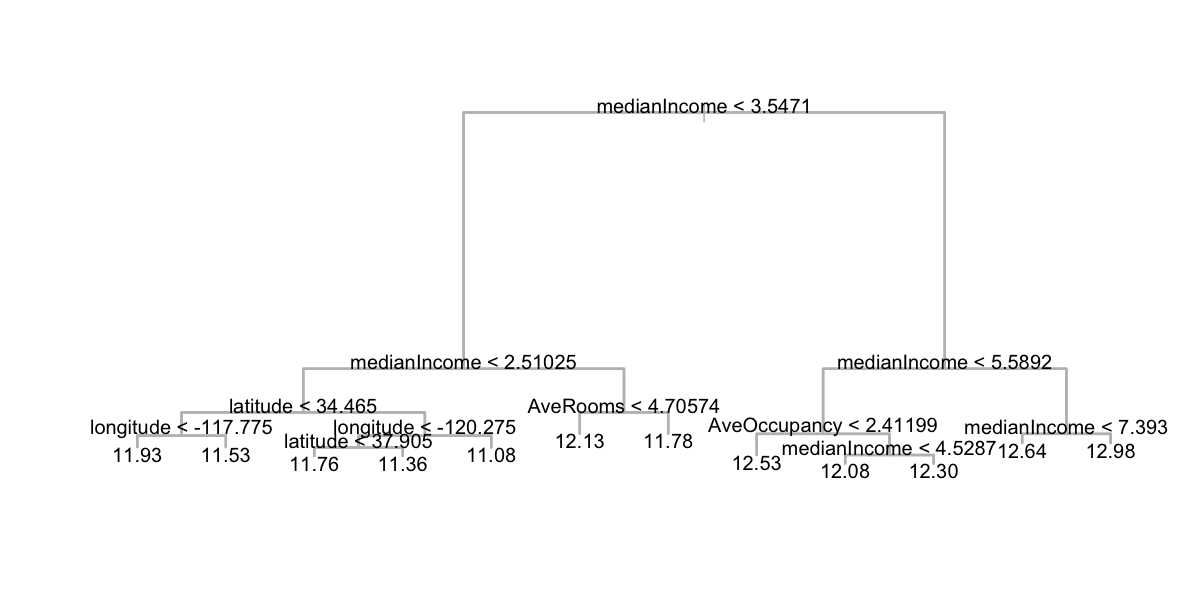

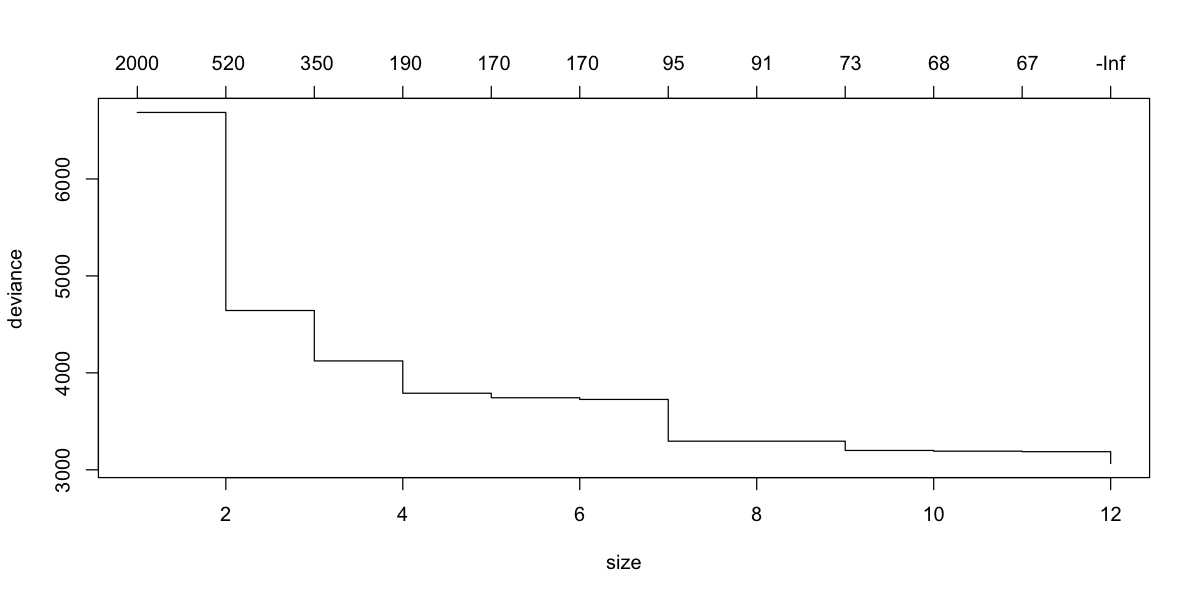

In [99]:
## Fit a single CART tree

## no need for interactions; the tree finds them automatically
catree <- tree(logMedVal ~ ., data=CAhousing) 
plot(catree, col=8, lwd=2)
text(catree)

## looks like the most complicated tree is best! 
cvca <- cv.tree(catree)
cvca$size[which.min(cvca$dev)]
plot(cvca)

In [100]:
#Now fit random forest using ranger

## limit the number of trees and the minimum tree size for speed
## add importance=TRUE so that we store the variable importance information
carf <- ranger(logMedVal ~ ., data=CAhousing,
               write.forest=TRUE, #save forest object for prediction
               num.tree=200, #number of trees to produce
               min.node.size=25, #minimum number of observations required for a leaf
               importance="impurity" #Track each splits out-of-bag sample performance
              )

In [101]:
#Can extract variable importance from random forest
sort(carf$variable.importance, decreasing=TRUE)

medianIncome         latitude        longitude     AveOccupancy 
       2421.5819        1002.0527         934.1604         580.2572 
        AveRooms housingMedianAge        AveBedrms       households 
        546.9451         210.8539         153.4039         121.2270 
      population 
        104.4619

12345678910

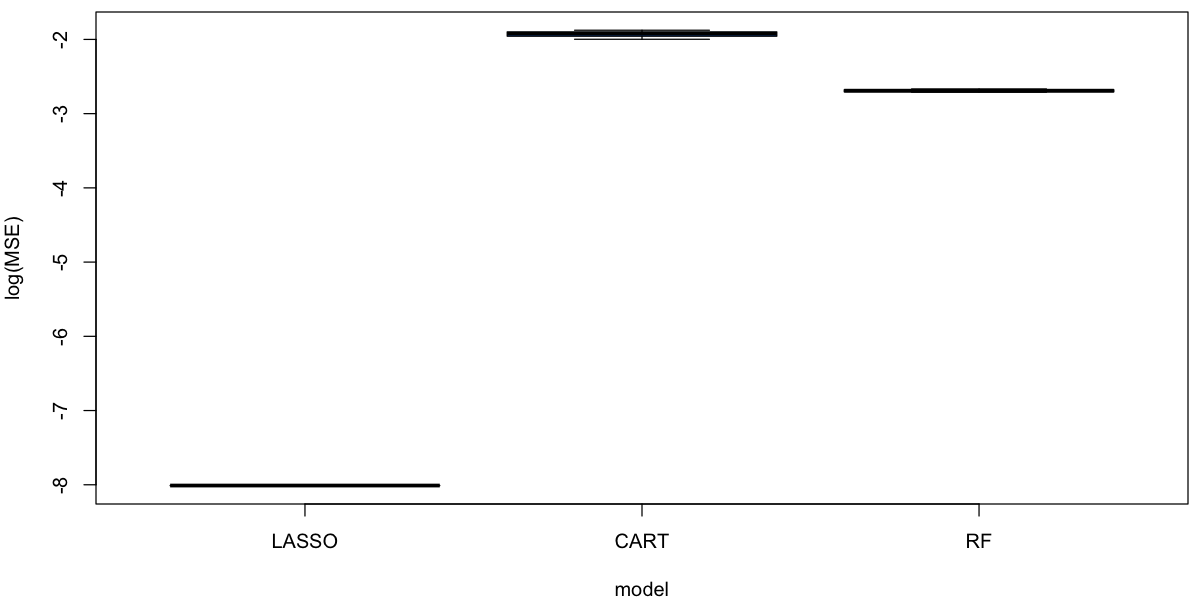

In [135]:
#NOTE: this differs from the textbook

##Calculate OOS MSE for each type of prediction method: lasso, CART tree, and random forest

#Create a list to store out of sample predictions for each model type
MSE <- list(LASSO=c(), CART=c(), RF=c())

#Construct for-loop to generate out-of-sample predictions
for(i in 1:10){
    
    #Sample indicies to be signal which observations in the dataset belong to the training data
    train <- sample(1:nrow(CAhousing), 5000)
    
    #Fit lasso linear model on training data
    lin <- cv.glmnet(x=XXca[train,], y=logMedVal[train], lambda.min.ratio=1e-4, nfolds=5)
    #Calculate predictions on out of sample data
    yhat.lin <- predict(lin, XXca[-train,])
    #MSE
    lasso_mse <- log(var(logMedVal[-train] - yhat.lin))
    #Calulate and store MSE
    MSE$LASSO <- c( MSE$LASSO, lasso_mse)
    
    #Fit CART tree model on training data
    rt <- tree(logMedVal ~ ., data=CAhousing[train,])
    #Calculate predictions on out of sample data
    yhat.rt <- predict(rt, newdata=CAhousing[-train,])
    #MSE
    rt_mse <- log(var(logMedVal[-train] - yhat.rt))
    #Calulate and store MSE
    MSE$CART <- c( MSE$CART, rt_mse)
    
    #Fit random forest model on training data
    rf <- ranger(logMedVal ~ ., data=CAhousing[train,], 
          num.tree=200, min.node.size=25, write.forest=TRUE)
    #Calculate predictions on out of sample data
    yhat.rf <- predict(rf, data=CAhousing[-train,])
    #MSE
    rf_mse <- log(var(logMedVal[-train] - yhat.rf$predictions))
    #Calulate and store MSE
    MSE$RF <- c( MSE$RF, rf_mse )
 
  cat(i)
} 
par(mai=c(.8,.8,.1,.1))
boxplot(as.data.frame(MSE), col="dodgerblue", xlab="model", ylab="log(MSE)")


## Heterogeneous Treatment Effects

Recent discoveries have found trees and random forests to be useful nonparametric estimators for heterogeneous treatment effects.

### Causal Trees

One such algorithm that is used is causal trees. This algorithm works by using a greedy algorithm to pick a split that maximizes the estimated treatment effect in both child nodes. (Look at algorithm on textbook page 254).

#### We will demonstrate the use of causal trees by returning to the Oregon Health example from earlier using the causaltree_OHIE.R script.

Recall that we were interested in observing the treatment effect of randomly selected eligibility for Medicaid on the probability that someone visits a primary care physician (PCP) at least once a year. The treatment variable is selected, indicating whether a person’s household was selected for eligibility, the response variable is binary doc_any_12m, and for covariates we have a set of results from a survey on subject demographics.

## Semiparametrics and Gaussian Processes

Semiparametric methods mix flexible function approximation with restrictive domain-specific structure. One such example is a Gaussian Process.

#### We will show the use of a Gaussian Process on the motorcycle data from the MASS library used earlier in this chapter. This will be walked through in the lagp.R script.